# Identifying Trajectories with MAGIK


In [28]:
#!pip install deeplay  
# Uncomment if using Colab/Kaggle.

In [ ]:
#!pip install gym opencv-python

^C


## Exploring the Cell Tracking Data

Import the packages

In [1]:
import tracker
import stats
import visualizer
import utils


... and load the data ...

In [5]:

training_frames = utils.loadVideo("comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1.mp4", as_gray=True)
training_gt = utils.loadDataFrame("comparisons/10X Ph- 9Fps Wash 1 16 P018cu R1_corrected.csv")


... and predict locations from Trackpy.

In [6]:
training_detections = tracker.determineCentroids(training_frames)

Frame 266: 70 features
                y            x         mass      size       ecc      signal  \
0       37.280067   833.369514  1294.213126  1.685588  0.133644  107.092342   
1       38.792347   964.479701   929.145303  1.543883  0.178551   99.721614   
2       41.991803    26.389344   105.791626  1.301008  0.228747   16.042173   
3       45.293094   274.346928   797.339343  1.520031  0.302929   92.784459   
4       57.961098   614.988558   189.471067  2.069723  0.135471    8.237872   
...           ...          ...          ...       ...       ...         ...   
19681  925.906169   901.572546  1028.815790  1.545993  0.247906  107.708343   
19682  935.942939  1014.047839   775.410685  1.546214  0.298090   90.725285   
19683  942.742763   481.973118  1080.658810  1.708854  0.228718   88.043749   
19684  991.084734   730.145308  1276.410903  1.842446  0.240619   81.339910   
19685  995.459641   324.852018   199.327473  1.353454  0.120612   28.156123   

       raw_mass        ep  f

## Creating a Graph From Initial Dectections

Implement a class to obtain a graph from the trackpy detections ...

In [ ]:
import numpy as np
import torch
from skimage import measure
from torch_geometric.data import Data

class GraphFromDetections:
    """Graph representation of the motion of cells."""

    def __init__(self, connectivity_radius, max_frame_distance):
        """Initialize graph."""
        self.connectivity_radius = connectivity_radius
        self.max_frame_distance = max_frame_distance

    #def get_node_attr(self, segmentation):
    #    """Compute node attributes."""
    #    labels = np.unique(segmentation)[1:]  # Labels without background
    #    node_attr = []
    #    for label in labels:
    #        mask = segmentation == label
    #        props = measure.regionprops(mask.astype(np.int32))[0]
    #        centroid = props.centroid / np.array(segmentation.shape)
    #        eccentricity = props.eccentricity
    #        node_attr.append([*centroid, eccentricity])
    #    return node_attr, labels

    def get_connectivity(self, node_attr, frames):
        """Compute connectivity."""
        xy = node_attr[:, :2]  # Extracted centroids
        distances = np.linalg.norm(xy[:, None] - xy, axis=-1)
        frame_diff = (frames[:, None] - frames) * -1
        mask = ((distances < self.connectivity_radius)
                & (frame_diff <= self.max_frame_distance) & (frame_diff > 0))
        edge_index, edge_attr = np.argwhere(mask), distances[mask]
        return edge_index, edge_attr

    def get_gt_connectivity(self, node_attr, frames, labels, edge_index, ground_truth, epsilon=1.0):
        """Compute ground truth connectivity."""
        src_cell = labels[edge_index[:, 0]]
        tgt_cell = labels[edge_index[:, 1]]
        self_connections_mask = src_cell == tgt_cell
    
        src_xy = node_attr[src_cell, :2]
        tgt_xy = node_attr[tgt_cell, :2]
        src_frame = frames[src_cell]
        tgt_frame = frames[tgt_cell]
        
        # Mark ground truth connections
        relation_mask = np.zeros(len(edge_index), dtype=bool)

        for i, (s, t) in enumerate(zip(src_cell, tgt_cell)):

            # Find the closest cell in the ground truth to the src and tgt
            src_cell_gt = ground_truth.loc[
                (ground_truth["frame"] == src_frame[i])
                & (np.abs(ground_truth["x"] - src_xy[i, 0]) < epsilon)
                & (np.abs(ground_truth["y"] - src_xy[i, 1]) < epsilon)
            ]
            tgt_cell_gt = ground_truth.loc[
                (ground_truth["frame"] == tgt_frame[i])
                & (np.abs(ground_truth["x"] - tgt_xy[i, 0]) < epsilon)
                & (np.abs(ground_truth["y"] - tgt_xy[i, 1]) < epsilon)
            ]
            if src_cell_gt.empty or tgt_cell_gt.empty:
                continue
            
            if src_cell_gt["sperm"].values[0] == tgt_cell_gt["sperm"].values[0]:
                relation_mask[i] = True
    
        gt_connectivity = self_connections_mask | relation_mask
        return gt_connectivity

    def __call__(self, detections, ground_truth):
        """Compute graph by reading each row of the dataframe."""

        node_attr, node_labels, node_frames = [], [], []

        for index, row in detections.iterrows():
            node_frames.append(int(row["frame"]))
            node_attr.append([row["x"], row["y"], row["mass"], row["size"], row["ecc"] ])
            node_labels.append(index)
        
        #node_attr = np.concatenate(node_attr)
        #node_labels = np.concatenate(node_labels)
        #frames = np.concatenate(frames)
    
        node_attr = np.array(node_attr)
        node_labels = np.array(node_labels)
        node_frames = np.array(node_frames)

        edge_index, edge_attr = self.get_connectivity(node_attr, node_frames)
        edge_gt = self.get_gt_connectivity(node_attr, node_frames, node_labels, edge_index, ground_truth)
    
        graph = Data(
            x=torch.tensor(node_attr, dtype=torch.float),
            edge_index=torch.tensor(edge_index.T, dtype=torch.long),
            edge_attr=torch.tensor(edge_attr[:, None], dtype=torch.float),
            distance=torch.tensor(edge_attr[:, None], dtype=torch.float),
            frames=torch.tensor(node_frames, dtype=torch.float),
            y=torch.tensor(edge_gt[:, None], dtype=torch.float),
        )
        return graph

... instantiate it and construct the training graph ...

In [34]:
graph_constructor = GraphFromDetections(connectivity_radius=15.0,
                                           max_frame_distance=2)

train_graph = graph_constructor(training_detections,training_gt)

(19686, 5)


... verify the number of nodes and edges ...

In [35]:
print("Number of nodes:", len(train_graph.x))
print("Number of edges:", len(train_graph.edge_index[0]))

Number of nodes: 19686
Number of edges: 39735


... and plot the graph.

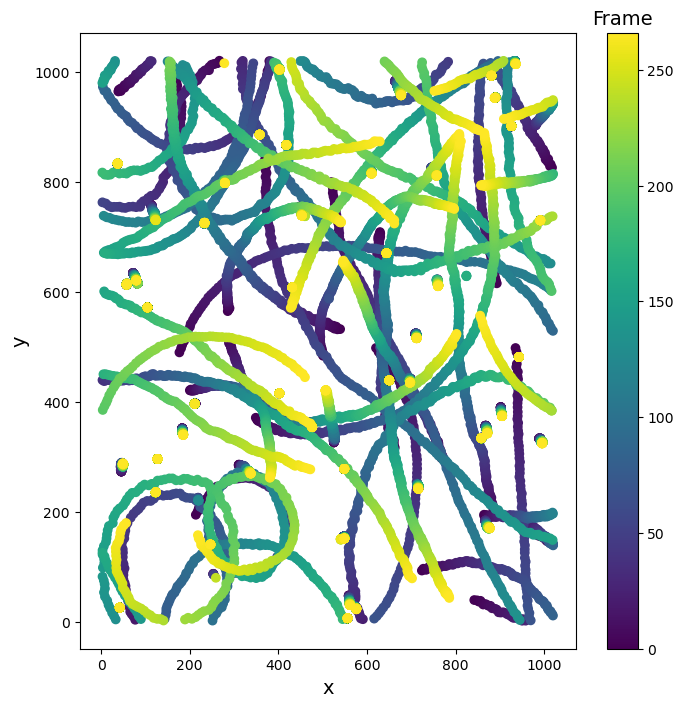

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i, j in train_graph.edge_index.T:
    plt.plot([train_graph.x[i, 1], train_graph.x[j, 1]],
             [train_graph.x[i, 0], train_graph.x[j, 0]], c="black", alpha=0.5)
plt.scatter(train_graph.x[:, 1], train_graph.x[:, 0],
            c=train_graph.frames, cmap="viridis", zorder=10)
cb = plt.colorbar()
cb.ax.set_title("Frame", fontsize=14)
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.show()

## Building a Training Dataset

Implement a class to prepare the graph dataset ...

In [38]:
class CellTracingDataset(torch.utils.data.Dataset):
    """Class to prepare the graph dataset."""

    def __init__(self, graph, Dt, dataset_size, transform=None):
        """Initialize the graph dataset."""
        self.graph, self.Dt, self.dataset_size, self.transform = \
            graph, Dt, dataset_size, transform

    def __len__(self):
        """Obtain length of dataset."""
        return self.dataset_size

    def __getitem__(self, idx):
        """Return a graph from the dataset."""
        frames, edge_index = self.graph.frames, self.graph.edge_index
        select_frame = np.random.randint(self.Dt, frames.max() + 1)

        start_frame = select_frame - self.Dt
        node_mask = (frames >= start_frame) & (frames < select_frame)
        node_attr = self.graph.x[node_mask]

        frame_pairs = torch.stack([frames[edge_index[0, :]],
                                   frames[edge_index[1, :]]], axis=1)
        edge_mask = (frame_pairs >= start_frame) & (frame_pairs < select_frame)
        edge_mask = edge_mask.all(axis=1)
        edge_index = edge_index[:, edge_mask] - edge_index[:, edge_mask].min()

        graph = Data(
            x=node_attr,
            edge_index=edge_index,
            edge_attr=self.graph.edge_attr[edge_mask],
            distance=self.graph.edge_attr[edge_mask],
            y=self.graph.y[edge_mask],  # Ground truth edges.
        )
        if self.transform: graph = self.transform(graph)
        return graph

... implement some classes to define random rotation and random flip ...

In [39]:
from math import cos, pi, sin

class RandomRotation:
    """Random rotation."""

    def __call__(self, graph):
        """Perform the random rotation."""
        graph = graph.clone()
        node_attr = graph.x[:, :2] - 0.5  # Centered positions
        angle = np.random.rand() * 2 * pi
        R = torch.tensor([[cos(angle), -sin(angle)], [sin(angle), cos(angle)]])
        rotated_node_attr = torch.matmul(node_attr, R)
        graph.x[:, :2] = rotated_node_attr + 0.5  # Restored positions
        return graph

class RandomFlip:
    """Random flip."""

    def __call__(self, graph):
        """Perform the random flip."""
        graph = graph.clone()
        node_attr = graph.x[:, :2] - 0.5  # Centered positions
        if np.random.randint(2): node_attr[:, 0] *= -1
        if np.random.randint(2): node_attr[:, 1] *= -1
        graph.x[:, :2] = node_attr + 0.5  # Restored positions
        return graph

... create the training dataset ...

In [40]:
from torchvision.transforms import Compose

train_set = CellTracingDataset(
    train_graph, Dt=5, dataset_size=512,
    transform=Compose([RandomRotation(), RandomFlip()]),
)

... and define the data loaders.

In [41]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)

## Making MAGIK

Define the MAGIK model ...

In [42]:
import deeplay as dl

model = dl.GraphToEdgeMAGIK([96,] * 4, 1, out_activation=torch.nn.Sigmoid)
model.encoder[0].configure(hidden_features=[32, 64], out_features=96,
                           out_activation=torch.nn.ReLU)
model.encoder[1].configure(hidden_features=[32, 64], out_features=96,
                           out_activation=torch.nn.ReLU)
model.head.configure(hidden_features=[64, 32])

MultiLayerPerceptron(
  (blocks): LayerList(
    (0): LinearBlock(
      (layer): Layer[Linear](in_features=96, out_features=64, bias=True)
      (activation): Layer[ReLU]()
    )
    (1): LinearBlock(
      (layer): Layer[Linear](in_features=64, out_features=32, bias=True)
      (activation): Layer[ReLU]()
    )
    (2): LinearBlock(
      (layer): Layer[Linear](in_features=32, out_features=1, bias=True)
      (activation): Layer[Sigmoid]()
    )
  )
)

... print the model ...

In [43]:
print(model)

GraphToEdgeMAGIK(
  (encoder): Parallel(
    (0-1): 2 x MultiLayerPerceptron(
      (blocks): LayerList(
        (0): LinearBlock(
          (layer): Layer[LazyLinear](out_features=32, bias=True)
          (activation): Layer[ReLU]()
        )
        (1): LinearBlock(
          (layer): Layer[Linear](in_features=32, out_features=64, bias=True)
          (activation): Layer[ReLU]()
        )
        (2): LinearBlock(
          (layer): Layer[Linear](in_features=64, out_features=96, bias=True)
          (activation): Layer[ReLU]()
        )
      )
    )
  )
  (backbone): MessagePassingNeuralNetwork(
    (blocks): LayerList(
      (0): LearnableDistancewWeighting(init_sigma=0.12, init_beta=4.0)
      (1-4): 4 x TransformPropagateUpdate(
        (transform): Transform(
          (combine): Cat()
          (layer): Layer[LazyLinear](out_features=96)
          (activation): Layer[ReLU]()
        )
        (propagate): WeightedSum()
        (update): Update(
          (combine): Cat()
     

... and train the MAGIK model.

In [44]:
classifier = dl.BinaryClassifier(model=model, optimizer=dl.Adam(lr=1e-3))
classifier = classifier.create()

trainer = dl.Trainer(max_epochs=10)
trainer.fit(classifier, train_loader)

c:\Users\hartda23\.conda\envs\deeptrack\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
W0521 11:21:43.835000 2044 site-packages\torch\distributed\elastic\multiprocessing\redirects.py:29] NOTE: Redirects are currently not supported in Windows or MacOs.
c:\Users\hartda23\.conda\envs\deeptrack\Lib\site-packages\lightning\pytorch\utilities\model_summary\model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | loss          | BCELoss          | 0      | train
1 | train_metrics | MetricCollection | 0      | train
2 | val_metrics   | MetricCollection | 0      | train
3 | test_metrics  | MetricColle

Epoch 9: 100%|██████████| 64/64 [00:03<00:00, 20.38it/s, v_num=1, train_loss_step=0.136, trainBinaryAccuracy_step=0.947, train_loss_epoch=0.184, trainBinaryAccuracy_epoch=0.940] 


## Evaluating Performance

Load the test data ...

In [46]:
testing_frames = utils.loadVideo("comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4", as_gray=True)
testing_gt = utils.loadDataFrame("comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1_corrected.csv")
testing_detections = tracker.determineCentroids(testing_frames)

Frame 263: 80 features


... construct the test graph ...

In [47]:
test_graph = graph_constructor(testing_detections,testing_gt)

(20569, 5)


... assess the model performance with the F1-score ...

In [48]:
from sklearn.metrics import f1_score

classifier.eval()
pred = classifier(test_graph)
predictions = pred.detach().numpy() > 0.5

ground_truth = test_graph.y

score = f1_score(ground_truth, predictions)
print(f"Test F1 score: {score}")

Test F1 score: 0.9486938471781616


... implement a class to compute trajectories from MAGIK results ...

In [49]:
import networkx as nx

class ComputeTrajectories:
    """Computation of trajectories."""

    def __call__(self, graph, predictions):
        """Compute trajectories."""
        pruned_edges = self.prune_edges(graph, predictions)
        pruned_graph = nx.Graph()
        pruned_graph.add_edges_from(pruned_edges)
        trajectories = list(nx.connected_components(pruned_graph))
        return trajectories

    def prune_edges(self, graph, predictions):
        """Prune edges."""
        pruned_edges = []
        frame_pairs = np.stack([graph.frames[graph.edge_index[0]],
                                graph.frames[graph.edge_index[1]]], axis=1)
        for src_cell in np.unique(graph.edge_index[0]):
            src_cell_mask = graph.edge_index[0] == src_cell
            tgt_cell_candidates = predictions[src_cell_mask] == True
            if np.any(tgt_cell_candidates):
                frame_diff = (frame_pairs[src_cell_mask, 1]
                              - frame_pairs[src_cell_mask, 0])
                min_frame_diff = frame_diff[tgt_cell_candidates].min()
                tgt_cell_mask = (tgt_cell_candidates
                                 & (frame_diff == min_frame_diff))
                edge = graph.edge_index[:, src_cell_mask][:, tgt_cell_mask]
                edge = edge.reshape(-1, 2)
                if len(edge) == 1:
                    pruned_edges.append(tuple(*edge.numpy()))
        return pruned_edges

... compute the trajectories ...

In [50]:
compute_trajectories = ComputeTrajectories()
trajectories = compute_trajectories(test_graph, predictions.squeeze())

... map trajectories back to csv file ...

In [ ]:
import pandas as pd

def trajectories_to_dataframe(trajectories, test_graph):

    # Create new dataframe
    result_df = pd.DataFrame(columns=["frame", "x", "y", "mass", "size", "ecc", "sperm"])

    for i, trajectory in enumerate(trajectories):
        for node_num in trajectory:
            node_attr = test_graph.x[node_num]
            frame = test_graph.frames[node_num]
            df_row = pd.DataFrame({
                "frame": [frame],
                "x": [node_attr[0]],
                "y": [node_attr[1]],
                "mass": [node_attr[2]],
                "size": [node_attr[3]],
                "ecc": [node_attr[4]],
                "sperm": [i]
            })
            result_df = pd.concat([result_df, df_row], ignore_index=True)
    result_df = result_df.astype({"frame": int, "sperm": int})
    return result_df

prediction_df = trajectories_to_dataframe(trajectories, test_graph)
        

... and visualize the cell trajectories as a video.

In [ ]:
videofile = "comparisons/10X Ph- 9Fps Wash Dil 1 16 P016an R1.mp4"
visualizer.runVisualization(videofile, prediction_df, "flow")

(172, 3)
Video Finished.


... compare to ground truth ...